<a name="Libraries"></a>
## 1. Installing and importing libraries


In [129]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.compose import TransformedTargetRegressor
# from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import datetime

import warnings
warnings.simplefilter(action='ignore')


import os
import random
import sklearn
import datetime
import numpy as np
import pandas as pd 
#import xgboost as xgb
from sklearn import metrics
#from google.colab import files
from sklearn.model_selection import train_test_split


from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore')

import warnings
warnings.simplefilter(action='ignore')

In [2]:
#Label Encoder
def label_enc(train_df, test_df, features):
    lbl_enc = LabelEncoder()
    full_data = pd.concat([train_df[features], test_df[features]],axis=0)
    for col in (features):
        print(col)
        lbl_enc.fit(full_data[col].values)
        train_df[col] = lbl_enc.transform(train_df[col])
        test_df[col] = lbl_enc.transform(test_df[col])
    return train_df, test_df

<a name="Data"></a>
## 2. Loading and previewing data

In [263]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [264]:
train_df.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,52
2020,52
2021,52
2022,49


In [265]:
test_df.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,52
2020,52
2021,52
2022,49


In [266]:
# Top 20 correlated features to the target
top20_corrs = abs(train_df.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                  1.000000
NitrogenDioxide_NO2_column_number_density                 0.288403
NitrogenDioxide_tropospheric_NO2_column_number_density    0.284160
NitrogenDioxide_NO2_slant_column_number_density           0.244449
SulphurDioxide_SO2_column_number_density_15km             0.072520
SulphurDioxide_SO2_slant_column_number_density            0.066350
SulphurDioxide_SO2_column_number_density                  0.060201
Cloud_surface_albedo                                      0.058965
UvAerosolLayerHeight_sensor_azimuth_angle                 0.054974
longitude                                                 0.053942
UvAerosolIndex_sensor_altitude                            0.044773
UvAerosolLayerHeight_solar_azimuth_angle                  0.043761
latitude                                                  0.043716
NitrogenDioxide_sensor_altitude                           0.040691
UvAerosolLayerHeight_aerosol_optical_depth                0.04

In [267]:
train_df.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [268]:
to_drop = list(train_df.isna().sum().sort_values(ascending = False)[:7].keys())

In [269]:
train_df = train_df.drop(to_drop, axis=1)
test_df = test_df.drop(to_drop, axis=1)

In [270]:
test_df = test_df.ffill()
train_df = train_df.ffill()

In [272]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train_df['location'] = [str(x) + '_' + str(y) for x, y in zip(train_df.latitude, train_df.longitude)]

# Filter based on one location
example_loc = train_df[train_df.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 4).mean()


In [273]:
#Performing Prinicipal Component Analysis on the data
pca =  PCA(1)
train_trans = pca.fit_transform(train_df.drop(['emission', 'ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1))
test_trans = pca.transform(test_df.drop(['ID_LAT_LON_YEAR_WEEK'], axis = 1))

In [274]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train_df.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train_df.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test_df.latitude, test_df.longitude = round(test_df.latitude, 2), round(test_df.longitude, 2)
test_df['location'] = [str(x) + '_' + str(y) for x, y in zip(test_df.latitude, test_df.longitude)]
test_roll_mean = test_df.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test_df.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Formaldehyde_sensor_azimuth_angle_roll_mean,UvAerosolIndex_absorbing_aerosol_index_roll_mean,UvAerosolIndex_sensor_altitude_roll_mean,UvAerosolIndex_sensor_azimuth_angle_roll_mean,UvAerosolIndex_sensor_zenith_angle_roll_mean,UvAerosolIndex_solar_azimuth_angle_roll_mean,UvAerosolIndex_solar_zenith_angle_roll_mean,Ozone_O3_column_number_density_roll_mean,Ozone_O3_column_number_density_amf_roll_mean,Ozone_O3_slant_column_number_density_roll_mean,Ozone_O3_effective_temperature_roll_mean,Ozone_cloud_fraction_roll_mean,Ozone_sensor_azimuth_angle_roll_mean,Ozone_sensor_zenith_angle_roll_mean,Ozone_solar_azimuth_angle_roll_mean,Ozone_solar_zenith_angle_roll_mean,Cloud_cloud_fraction_roll_mean,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000129,0.438820,0.000048,0.094695,-49.026000,55.935104,-92.364110,26.771698,0.000020,0.025489,2265.509526,825.506467,836164.043391,-68.503061,42.947479,-92.938253,26.921882,0.000075,0.000033,0.000041,0.000157,9183.985574,-1.185398,0.062243,835556.726552,7.386257,55.926608,-89.234521,19.556248,0.000202,0.976496,0.000122,0.101812,26.905807,-92.465549,55.678580,-50.946999,-0.882496,835941.380262,-29.637287,51.397448,-91.441108,23.898942,0.120184,2.852682,0.347372,229.000707,0.191387,-45.886237,50.962113,-92.252723,25.979651,0.235195,79559.852761,1581.442797,85797.362245,1244.571120,7.992071,0.259796,17.630362,45.737880,-89.109364,18.387366
2,0.000120,0.568128,0.000053,0.094655,-0.520018,44.992116,-88.070204,21.958601,0.000022,0.025030,2250.688556,829.001006,835980.980682,-26.914239,34.703339,-89.355702,23.776103,0.000081,0.000039,0.000041,0.000156,8659.905902,-1.235564,0.049329,835426.511708,18.527059,51.296027,-85.488940,17.352464,

In [275]:
test_roll_mean.fillna(test_roll_mean.mean(), inplace=True)
train_roll_mean.fillna(train_roll_mean.mean(), inplace=True)

In [276]:
#Train
train_df = train_df.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_df = test_df.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,location,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Formaldehyde_s

In [230]:
# test_roll_mean.head()

In [231]:
# train_roll_mean.head()

In [232]:
pca_name = {
'sulphur' : ['SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km'],

'carbon' : ['CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle'],

'nitrogen' : ['CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'NitrogenDioxide_tropopause_pressure',
       'NitrogenDioxide_absorbing_aerosol_index',
       'NitrogenDioxide_cloud_fraction', 'NitrogenDioxide_sensor_altitude',
       'NitrogenDioxide_sensor_azimuth_angle',
       'NitrogenDioxide_sensor_zenith_angle',
       'NitrogenDioxide_solar_azimuth_angle',
       'NitrogenDioxide_solar_zenith_angle'],

'formalide' : ['Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'Formaldehyde_solar_zenith_angle',
       'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle',
       'Formaldehyde_sensor_azimuth_angle'],

'uv' : ['UvAerosolIndex_absorbing_aerosol_index',
       'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle',
       'UvAerosolIndex_sensor_zenith_angle',
       'UvAerosolIndex_solar_azimuth_angle',
       'UvAerosolIndex_solar_zenith_angle'],

'ozone' : ['Ozone_O3_column_number_density',
       'Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle',
       'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle'],

'cloud' : ['Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
       'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
       'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
       'Cloud_surface_albedo', 'Cloud_sensor_azimuth_angle',
       'Cloud_sensor_zenith_angle', 'Cloud_solar_azimuth_angle',
       'Cloud_solar_zenith_angle']}

# pca_col = [sulphur, carbon, nitrogen, formalide, uv, ozone, cloud]

In [277]:
#Performing Prinicipal Component Analysis on the data

# col_name = ['sulphur', 'carbon', 'nitrogen', 'formalide', 'uv', 'ozone', 'cloud']
for name in pca_name:
    col = pca_name[name]
    pca =  PCA(1)
    pca_trans = pca.fit_transform(train_df[col])
    pca_t_trans = pca.transform(test_df[col])
    
    
    train_df = pd.merge(train_df, pd.DataFrame(pca_trans, columns=[name+'pca1']),left_index=True,right_index=True)
    test_df = pd.merge(test_df, pd.DataFrame(pca_t_trans,columns=[name+'pca1']),left_index=True,right_index=True)
    
#Merging the reduced data to the real dataset
train_df = pd.merge(train_df, pd.DataFrame(train_trans, columns=['pca1']),left_index=True,right_index=True)
test_df = pd.merge(test_df, pd.DataFrame(test_trans,columns=['pca1']),left_index=True,right_index=True)

In [278]:
train_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,location,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Forma

In [279]:
train_df.shape

(74005, 141)

In [69]:
# col1 = ['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no']
# #col2 = ['device']
# #col3 = ['humidity', 'temp_mean']
# location = ['latitude', 'longitude']
# chem = [
#         'NitrogenDioxide_NO2_column_number_density',
#        'NitrogenDioxide_tropospheric_NO2_column_number_density',
#         'NitrogenDioxide_NO2_slant_column_number_density',
#        'SulphurDioxide_SO2_column_number_density_15km',
#         'SulphurDioxide_SO2_slant_column_number_density',
#         'SulphurDioxide_SO2_column_number_density',
#         'Cloud_surface_albedo',
#         # 'UvAerosolLayerHeight_sensor_azimuth_angle', 
#         # 'UvAerosolLayerHeight_solar_azimuth_angle',
#         'NitrogenDioxide_sensor_altitude',
#         # 'UvAerosolLayerHeight_aerosol_optical_depth',
#         'CarbonMonoxide_sensor_altitude',
#         'CarbonMonoxide_sensor_altitude',
#         # 'UvAerosolLayerHeight_aerosol_pressure',
#         'SulphurDioxide_SO2_column_number_density_amf',
#         # 'UvAerosolLayerHeight_aerosol_height',
#         'CarbonMonoxide_H2O_column_number_density']

# pcas = ['sulphurpca1', 'sulphurpca2',
#        'carbonpca1', 'carbonpca2', 'nitrogenpca1', 'nitrogenpca2',
#        'formalidepca1', 'formalidepca2', 'uvpca1', 'uvpca2', 'ozonepca1',
#        'ozonepca2', 'cloudpca1', 'cloudpca2', 'pca1', 'pca2', 'pca3']

# target = ['emission']
# feat = col1 + location + chem + pcas
# train_df = train_df[feat + target]
# test_df = test_df[feat]

In [280]:
num_col = train_df.select_dtypes(exclude='O').columns.difference(['emission', 'latitude', 'longitude', 'year', 'week_no'])
#train_df.temp_mean = train_df.temp_mean.fillna(train_df.temp_mean.median())
for data in (train_df, test_df):
    for feat in num_col:
        data[feat] = data[feat].ffill()

In [281]:
train_df

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,location,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Forma

In [72]:
# train_eng.head()

In [282]:
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

KeyboardInterrupt: 

In [75]:
random_seed = 2022
data_km = train_df.drop(['ID_LAT_LON_YEAR_WEEK', 'emission','location'], axis = 1)
km = KMeans(n_clusters = 40, random_state = random_seed)
train_df['cluster'] = km.fit_predict(data_km)

In [76]:
random_seed = 2022
data_km = test_df.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1)
km = KMeans(n_clusters = 40, random_state = random_seed)
test_df['cluster'] = km.fit_predict(data_km)

In [78]:
# len(set([str(x) + '_' + str(y) for x, y in zip(train_eng.latitude, train_eng.longitude)]))

In [42]:
# train_df.location.value_counts()

In [ ]:
# test_eng.head()

In [ ]:
# train_df.columns

In [ ]:
# train_eng.head()

In [ ]:
# Top 20 correlated features to the target
top20_corrs = abs(train_eng.corr()['emission']).sort_values(ascending = False).head(20)
# top20_corrs

In [283]:
train_eng = train_df.copy()
test_eng = test_df.copy()

In [110]:
train_eng["Sensor difference"] = (train_eng["NitrogenDioxide_sensor_altitude_roll_mean"] - train_eng["NitrogenDioxide_sensor_altitude"]).abs()
train_eng["Sensor div"] = (train_eng["NitrogenDioxide_sensor_altitude_roll_mean"] / train_eng["NitrogenDioxide_sensor_altitude"]).abs()
train_eng["Sensor R/T"] = (train_eng["NitrogenDioxide_sensor_altitude_roll_mean"] / train_eng["NitrogenDioxide_sensor_altitude"]).abs()
train_eng["SD"] = train_eng[["NitrogenDioxide_sensor_altitude_roll_mean","NitrogenDioxide_sensor_altitude"]].std(axis=1)
train_eng["Mean"] = train_eng[["NitrogenDioxide_sensor_altitude_roll_mean","NitrogenDioxide_sensor_altitude"]].mean(axis=1)

test_eng["Sensor difference"] = (test_eng["NitrogenDioxide_sensor_altitude_roll_mean"] - test_eng["NitrogenDioxide_sensor_altitude"]).abs()
test_eng["Sensor div"] = (test_eng["NitrogenDioxide_sensor_altitude_roll_mean"] / test_eng["NitrogenDioxide_sensor_altitude"]).abs()
test_eng["Sensor R/T"] = (test_eng["NitrogenDioxide_sensor_altitude_roll_mean"] / test_eng["NitrogenDioxide_sensor_altitude"]).abs()
test_eng["SD"] = test_eng[["NitrogenDioxide_sensor_altitude_roll_mean","NitrogenDioxide_sensor_altitude"]].std(axis=1)
test_eng["Mean"] = test_eng[["NitrogenDioxide_sensor_altitude_roll_mean","NitrogenDioxide_sensor_altitude"]].mean(axis=1)

In [111]:
train_df.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       ...
       'uvpca1', 'uvpca2', 'ozonepca1', 'ozonepca2', 'cloudpca1', 'cloudpca2',
       'pca1', 'pca2', 'pca3', 'cluster'],
      dtype='object', length=151)

In [188]:
col1 = ['ID_LAT_LON_YEAR_WEEK']
#col2 = ['device']
#col3 = ['humidity', 'temp_mean']
location = ['Sensor difference', 'Sensor div','Sensor R/T','SD','Mean','cluster','longitude','latitude']
chem = [
        'NitrogenDioxide_NO2_column_number_density_roll_mean',
       'NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean',
        'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
        'NitrogenDioxide_NO2_slant_column_number_density_roll_mean',
        'NitrogenDioxide_NO2_slant_column_number_density',
        'SulphurDioxide_SO2_column_number_density_15km_roll_mean',
        'SulphurDioxide_SO2_slant_column_number_density_roll_mean', 
        'SulphurDioxide_SO2_column_number_density_roll_mean',
        'SulphurDioxide_SO2_column_number_density_15km',
        'SulphurDioxide_SO2_slant_column_number_density',
        # 'SulphurDioxide_SO2_slant_column_number_density',
        'Cloud_surface_albedo_roll_mean',
        'Cloud_surface_albedo',
        'SulphurDioxide_SO2_column_number_density',
        'NitrogenDioxide_sensor_altitude_roll_mean',
        'NitrogenDioxide_sensor_altitude',
        # 'UvAerosolLayerHeight_solar_azimuth_angle_roll_mean'        
]

pcas = ['sulphurpca1', 'sulphurpca2',
       'carbonpca1', 'carbonpca2', 'nitrogenpca1', 'nitrogenpca2',
       'formalidepca1', 'formalidepca2', 'uvpca1', 'uvpca2', 'ozonepca1',
       'ozonepca2', 'cloudpca1', 'cloudpca2', 'pca1', 'pca2', 'pca3']

target = ['emission']
feat = location + pcas
train_eng = train_eng[feat + target]
test_eng = test_eng[feat]

In [189]:
train_eng.shape, test_eng.shape

((74005, 26), (28085, 25))

In [284]:
train_eng.drop(['location'],inplace=True,axis=1)
test_eng.drop(['location'],inplace=True,axis=1)

In [285]:
train_eng.drop(['ID_LAT_LON_YEAR_WEEK'],inplace=True,axis=1)
test_eng.drop(['ID_LAT_LON_YEAR_WEEK'],inplace=True,axis=1)

In [115]:
train_eng.drop(['SulphurDioxide_SO2_slant_column_number_density'],inplace=True,axis=1)
test_eng.drop(['SulphurDioxide_SO2_slant_column_number_density'],inplace=True,axis=1)

In [116]:
# train_eng.drop(['SulphurDioxide_SO2_slant_column_number_density'],inplace=True,axis=1)

In [328]:
y = train_eng["emission"] #Our target column is the price_actual variable
X = train_eng.drop(["emission"], axis=1) #remove what we dont need from the dataset

X.shape, train_eng.shape, test_eng.shape 

((74005, 138), (74005, 139), (28085, 138))

In [287]:
28085/74005

0.37950138504155123

In [246]:
X.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,location,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,CarbonMonoxide_H2O_column_number_density_roll_mean,CarbonMonoxide_cloud_height_roll_mean,CarbonMonoxide_sensor_altitude_roll_mean,CarbonMonoxide_sensor_azimuth_angle_roll_mean,CarbonMonoxide_sensor_zenith_angle_roll_mean,CarbonMonoxide_solar_azimuth_angle_roll_mean,CarbonMonoxide_solar_zenith_angle_roll_mean,NitrogenDioxide_NO2_column_number_density_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_slant_column_number_density_roll_mean,NitrogenDioxide_tropopause_pressure_roll_mean,NitrogenDioxide_absorbing_aerosol_index_roll_mean,NitrogenDioxide_cloud_fraction_roll_mean,NitrogenDioxide_sensor_altitude_roll_mean,NitrogenDioxide_sensor_azimuth_angle_roll_mean,NitrogenDioxide_sensor_zenith_angle_roll_mean,NitrogenDioxide_solar_azimuth_angle_roll_mean,NitrogenDioxide_solar_zenith_angle_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_roll_mean,Formaldehyde_tropospheric_HCHO_column_number_density_amf_roll_mean,Formaldehyde_HCHO_slant_column_number_density_roll_mean,Formaldehyde_cloud_fraction_roll_mean,Formaldehyde_solar_zenith_angle_roll_mean,Formaldehyde_solar_azimuth_angle_roll_mean,Formaldehyde_sensor_zenith_angle_roll_mean,Formaldehyde_sensor_azimuth_angle_r

In [119]:
X.columns

Index(['Sensor difference', 'Sensor div', 'Sensor R/T', 'SD', 'Mean',
       'cluster', 'longitude', 'latitude',
       'NitrogenDioxide_NO2_column_number_density_roll_mean',
       'NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density_roll_mean',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'SulphurDioxide_SO2_column_number_density_15km_roll_mean',
       'SulphurDioxide_SO2_slant_column_number_density_roll_mean',
       'SulphurDioxide_SO2_column_number_density_roll_mean',
       'SulphurDioxide_SO2_column_number_density_15km',
       'Cloud_surface_albedo_roll_mean', 'Cloud_surface_albedo',
       'SulphurDioxide_SO2_column_number_density',
       'NitrogenDioxide_sensor_altitude_roll_mean',
       'NitrogenDioxide_sensor_altitude', 'sulphurpca1', 'sulphurpca2',
       'carbonpca

In [120]:
# 'SulphurDioxide_SO2_slant_column_number_density'

In [329]:
# X=X[new_feat]

In [330]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 202, shuffle=False)

In [331]:
X.shape

(74005, 70)

In [333]:
clf = CatBoostRegressor(loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42)

clf.fit(X_train, y_train,
             verbose=0)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

RMSE Score: 13284.469751104412


In [121]:
cb_model = CatBoostRegressor(iterations=30000,
                             learning_rate=0.045,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=300)
cb_model.fit(X, y,
             use_best_model=True,
             verbose=50)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 50492.2455069	total: 81.1ms	remaining: 40m 33s
50:	learn: 13201.8163526	total: 3.96s	remaining: 38m 43s
100:	learn: 8797.5372073	total: 7.4s	remaining: 36m 30s
150:	learn: 6972.2990112	total: 10.9s	remaining: 36m 4s
200:	learn: 5892.8025912	total: 14.4s	remaining: 35m 36s
250:	learn: 5153.7268252	total: 17.9s	remaining: 35m 19s
300:	learn: 4622.8566012	total: 21.4s	remaining: 35m 12s
350:	learn: 4351.8851082	total: 24.8s	remaining: 34m 56s
400:	learn: 4079.1477643	total: 28.2s	remaining: 34m 44s
450:	learn: 3827.5767376	total: 31.8s	remaining: 34m 46s
500:	learn: 3611.6151109	total: 35.2s	remaining: 34m 31s
550:	learn: 3447.6843445	total: 38.5s	remaining: 34m 17s
600:	learn: 3302.0729783	total: 42.4s	remaining: 34m 34s
650:	learn: 3173.1237210	total: 45.7s	remaining: 34m 21s
700:	learn: 3029.9800987	total: 49.3s	remaining: 34m 21s
750:	learn: 2900.2937972	total: 52.8s	remaining: 34m 15s
800:	learn: 2814.9538336	total: 56.5s	remaining: 34m 18s
850:	learn: 2721.6297498	total: 1

In [35]:
cb_model = CatBoostRegressor(iterations=30000,
                             learning_rate=0.045,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=300)
cb_model.fit(X, y,
             use_best_model=True,
             verbose=50)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 50495.7597701	total: 86.6ms	remaining: 43m 17s
50:	learn: 12849.2264276	total: 1.74s	remaining: 17m
100:	learn: 8535.7475567	total: 3.36s	remaining: 16m 34s
150:	learn: 6932.9385962	total: 4.93s	remaining: 16m 14s
200:	learn: 6086.0534182	total: 7.19s	remaining: 17m 46s
250:	learn: 5564.3271842	total: 9.6s	remaining: 18m 58s
300:	learn: 5085.4592824	total: 11.2s	remaining: 18m 21s
350:	learn: 4747.0379045	total: 12.8s	remaining: 17m 57s
400:	learn: 4429.3618949	total: 14.4s	remaining: 17m 39s
450:	learn: 4176.5950028	total: 15.9s	remaining: 17m 24s
500:	learn: 3975.5998538	total: 17.6s	remaining: 17m 14s
550:	learn: 3775.7315808	total: 19.8s	remaining: 17m 36s
600:	learn: 3618.8390291	total: 22.2s	remaining: 18m 7s
650:	learn: 3457.6556876	total: 23.8s	remaining: 17m 53s
700:	learn: 3295.8536031	total: 25.4s	remaining: 17m 42s
750:	learn: 3189.4671908	total: 27s	remaining: 17m 32s
800:	learn: 3086.9620584	total: 28.6s	remaining: 17m 22s
850:	learn: 2965.1279429	total: 30.2s	r

In [304]:
p3 = (clf.predict(test_eng))

In [215]:
y

0         88.875670
1         91.723114
2         92.883870
3        101.597170
4         98.699180
            ...    
74000     34.115240
74001     35.865158
74002     35.511803
74003     35.907146
74004     28.858446
Name: emission, Length: 74005, dtype: float64

In [303]:
p3

array([2156.32599096, 2307.24908026, 2051.99004745, ..., 1274.67162704,
       1399.46476213, 1036.10424727])

In [126]:
CATBoostPred1 = (cb_model.predict(test_eng))

In [127]:
sub = pd.read_csv('SampleSubmission.csv')
sub.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [208]:
p3

array([-857.86017126, 2882.37902608, 2902.42566745, ..., 5513.87197651,
       3893.55705897, 5456.30965965])

In [209]:
p3 = np.abs(p3)

In [128]:
CATBoostPred1

array([-1687.24292971,  1341.59009031,  2381.92231628, ...,
        6116.02937511,  6979.60451506,  6239.96342022])

In [305]:
submission = pd.DataFrame({"ID_LAT_LON_YEAR_WEEK":sub['ID_LAT_LON_YEAR_WEEK'], "emission": p3})
submission.to_csv("process1.csv", index=False)

In [125]:
submission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0.000000
1,ID_-23.53_27.47_2019_2,1341.590090
2,ID_-23.53_27.47_2019_3,2381.922316
3,ID_-23.53_27.47_2019_4,1876.705528
4,ID_-23.53_27.47_2019_5,14035.669874


In [ ]:
train_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
rmse_score = []

target = y
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y)):
    print(50*'-')
    print(f'Fold {fold_+1} / {n_splits}' )
    print(100*'-')
    X_trn, X_val, X_test = X.iloc[trn_idx], X.iloc[val_idx], test
    y_trn, y_val = np.log(y.iloc[trn_idx]), np.log(y.iloc[val_idx])

    clf = CatBoostRegressor(random_state = SEED, **opt_params)#n_estimators = 5000, learning_rate = 0.02, depth = 8, verbose = 0,
#                             random_state = 42,
#                             use_best_model = True,  task_type='GPU', loss_function='RMSE',)
    
    clf.fit(X_trn,y_trn,eval_set=[(X_val, y_val)], early_stopping_rounds = 200, verbose = 1000)

    predTrain = np.exp(clf.predict(X_val))
    train_preds[val_idx] = predTrain
    
    error = rmse(target.iloc[val_idx], predTrain, squared = False)
    rmse_score.append(error)
    print(f"RMSE : {error}")

    predTest = np.exp(clf.predict(X_test))
    predTest[predTest < 0] = 0
    test_preds += predTest
    print(100*'-')

print(f"Overall RMSE : {np.mean(rmse_score)}")

In [132]:
from lightgbm import LGBMRegressor

In [133]:
kfold =KFold(n_splits=10,random_state=43,shuffle=True)
scoreslgb = []
test_scoreslgb = np.zeros(len(test_eng))
for fold,(tr_in,te_in) in enumerate(kfold.split(X,y)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    lgb = LGBMRegressor(n_estimators=5000, learning_rate=0.1,
                            max_depth=7,random_state = 7,
                        min_child_weight = 12, num_leaves = 32)#10,7
    lgb.fit(X_train,y_train)
    _ = lgb.predict(X_test)
    print(rmse(y_test, _, squared = False))
    scoreslgb.append(rmse(y_test,_, squared=False))
    test_scoreslgb += lgb.predict(test_eng)

============================Fold0================================
11717.410878249018
============================Fold1================================
12924.277229269697
============================Fold2================================
11955.678974582122
============================Fold3================================
7950.695801935318
============================Fold4================================
10985.488039406064
============================Fold5================================
11788.271356031884
============================Fold6================================
11956.508827736394
============================Fold7================================
9784.256057677072
============================Fold8================================
12095.67384015332
============================Fold9================================
11332.407018937363


In [145]:
kfold =KFold(n_splits=10,random_state=43,shuffle=True)
scorescat = []
test_scorescat = np.zeros(len(test_eng))
for fold,(tr_in,te_in) in enumerate(kfold.split(X,y)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    cat = CatBoostRegressor(random_seed=2022)#10,7
    cat.fit(X_train,y_train, verbose=1000)
    _ = cat.predict(X_test)
    print(rmse(y_test, _, squared = False))
    scorescat.append(rmse(y_test,_, squared=False))
    test_scorescat += cat.predict(test_eng)

============================Fold0================================
Learning rate set to 0.079486
0:	learn: 48598.6493729	total: 41.4ms	remaining: 41.4s
999:	learn: 2569.1899401	total: 39.9s	remaining: 0us
4338.828187049518
============================Fold1================================
Learning rate set to 0.079486
0:	learn: 47808.5281166	total: 42.5ms	remaining: 42.4s
999:	learn: 2547.0090654	total: 37.4s	remaining: 0us
5533.925531837088
============================Fold2================================
Learning rate set to 0.079486
0:	learn: 48410.7290505	total: 38.1ms	remaining: 38.1s
999:	learn: 2542.3588829	total: 38.6s	remaining: 0us
4974.953801163914
============================Fold3================================
Learning rate set to 0.079486
0:	learn: 50382.7887768	total: 37.8ms	remaining: 37.7s
999:	learn: 2656.5070950	total: 37.9s	remaining: 0us
3375.3875022276357
============================Fold4================================
Learning rate set to 0.079486
0:	learn: 48119

In [146]:
cat_pred = test_scorescat / 10

In [147]:
cat_pred

array([ 829.41860219, 1991.64478703, 2047.69977149, ..., 6503.35429848,
       6906.21260435, 6358.20574073])

In [136]:
lgb_pred= test_scoreslgb/10

In [210]:
submission = pd.DataFrame({"ID_LAT_LON_YEAR_WEEK":sub['ID_LAT_LON_YEAR_WEEK'], "emission":p3 })
submission.to_csv("fewpca2.csv", index=False)

In [138]:
(lgb_pred + CATBoostPred1)/2

array([ 1488.73936771,  -317.41033207, -1042.93442937, ...,
        5703.58264337,  5435.32990697,  5656.48948187])

In [142]:
ense = np.clip((lgb_pred*0.3) + (CATBoostPred1*0.7), 0, a_max=None)

In [155]:
submission = pd.DataFrame({"ID_LAT_LON_YEAR_WEEK":sub['ID_LAT_LON_YEAR_WEEK'], "emission":___})
submission.to_csv("cat+cat1.csv", index=False)

In [151]:
__ = np.clip(((cat_pred + CATBoostPred1 + lgb_pred)/3 )*.4 + CATBoostPred1 *0.6, 0, a_max=None)

In [154]:
___ = np.clip(cat_pred *0.4 + CATBoostPred1 *0.6, 0, a_max=None)

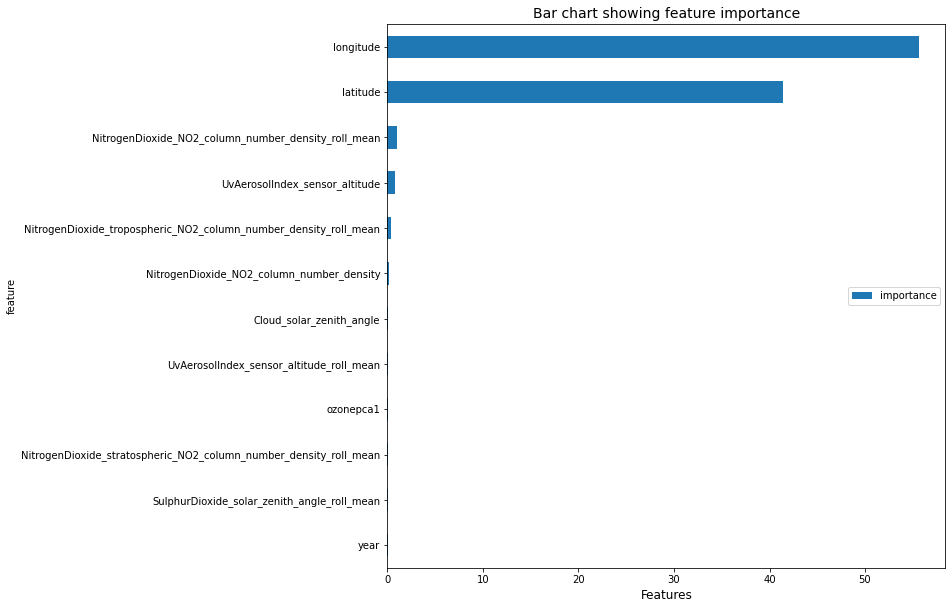

In [258]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [298]:
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)

In [326]:
new_feat = list(impo_df.reset_index()['feature'][:70])

In [307]:
p1 = pd.read_csv('winning_crack1__1.csv')['emission']
p2 = pd.read_csv('crack1__1 (1).csv')['emission']

In [306]:
p4 = pd.read_csv('process.csv')['emission']

In [323]:
combo1 = (p1 *.5 + p2*0.2 + p3*.3)

In [324]:
combo1

0         1880.558694
1         3084.891066
2         2637.265231
3         3081.313629
4        11715.518295
             ...     
28080     9176.763348
28081     9704.262174
28082     9626.076385
28083     9818.085181
28084     9967.670868
Name: emission, Length: 28085, dtype: float64

In [310]:
p4

0        2156.325991
1        2307.249080
2        2051.990047
3        2221.944739
4        2173.373487
            ...     
28080    1135.228823
28081    1165.140077
28082    1274.671627
28083    1399.464762
28084    1036.104247
Name: emission, Length: 28085, dtype: float64

In [185]:
combo = p1*0.7+p2*0.2+cat_pred*0.1 #85

# combo = (p1*0.5+lgb_pred*0.5) *.1 + p1*.9

In [325]:
submission = pd.DataFrame({"ID_LAT_LON_YEAR_WEEK":sub['ID_LAT_LON_YEAR_WEEK'], "emission":combo1})
submission.to_csv("combo3.csv", index=False)

In [183]:
p1

0         2487.838795
1         3496.575034
2         2951.819507
3         3535.434786
4        13770.594267
             ...     
28080    12606.730577
28081    13532.011239
28082    13254.984932
28083    13525.777044
28084    12878.841962
Name: emission, Length: 28085, dtype: float64

In [182]:
combo

0         2596.682939
1         3222.925744
2         2580.838973
3         3230.619857
4        14065.654881
             ...     
28080    12241.688908
28081    13119.722396
28082    12856.792481
28083    13044.040957
28084    12488.550641
Name: emission, Length: 28085, dtype: float64

In [175]:
lgb_pred

array([ 4664.72166513, -1976.41075446, -4467.79117502, ...,
        5291.13591163,  3891.05529888,  5073.01554352])